# What is this?
A notebook collecting some potentially non-obvious examples of computation
frames and how we can navigate them.

In [52]:
from mandala._next.imports import *
from mandala._next.common_imports import *
from mandala._next.utils import *

In [53]:
storage = Storage()

@op
def get_sum(elts: MList[int]) -> int:
    return sum(elts)

@op
def primes_below(n: int) -> MList[int]:
    primes = []
    for i in range(2, n):
        for p in primes:
            if i % p == 0:
                break
        else:
            primes.append(i)
    return primes

@op
def chunked_square(elts: MList[int]) -> MList[int]:
    # a model for an op that does something on chunks of a big thing
    # to prevent OOM errors
    return [x*x for x in elts]

with storage:
    n = 10
    primes = primes_below(n)
    sum_primes = get_sum(primes)
assert len(primes) == 4
# check indexing
assert storage.unwrap(primes[0]) == 2
assert storage.unwrap(primes[:2]) == [2, 3]

### lists w/ overlapping elements
with storage:
    n = 100
    primes = primes_below(n)
    for i in range(0, len(primes), 2):
        sum_primes = get_sum(primes[:i+1])

with storage:
    elts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    squares = chunked_square(elts)


Found the following number elements to expand in direction back:
  {'elts': 1, 'output_0': 0}


Found 1 calls to expand
Expanding call group for op '__make_list__' with 1 calls, connections:
  output_0: ('elts',)
Adding function __make_list__ for group ('__make_list__', (('output_0', ('elts',)),))
Found the following number elements to expand in direction back:
  {'elts': 0, 'elts_0': 10, 'output_0': 0}
Found 0 calls to expand
Found the following number elements to expand in direction forward:
  {'elts': 0, 'elts_0': 0, 'output_0': 1}
Found 10 calls to expand
Expanding call group for op '__get_list_item__' with 9 calls, connections:
  attr: ('elts_0',), obj: ('output_0',)
Adding function __get_list_item__ for group ('__get_list_item__', (('attr', ('elts_0',)), ('obj', ('output_0',))))
Expanding call group for op '__get_list_item__' with 1 calls, connections:
  obj: ('output_0',)
Adding function __get_list_item___0 for group ('__get_list_item__', (('obj', ('output_0',)),))
Found the following number elements to expand in direction forward:
  {'elts': 0, 'elts_0': 0, 'output_0': 0,

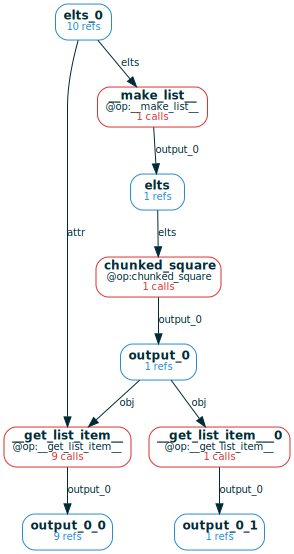

In [57]:
cf = storage.cf(chunked_square)
cf.expand(verbose=True).draw()

In [ ]:
# set the logging level to DEBUG
# get the root logger
logger = logging.getLogger()
# set the logging level
logger.setLevel(logging.DEBUG)

In [2]:
### some example functions
@op
def inc(x: int) -> int:
    return x + 1

@op
def divmod(x: int, y: int) -> Tuple[int, int]:
    return x // y, x % y

@op # a function with a wild input signature
def add(x, *args, y: int = 1, **kwargs):
    # just sum everything
    return x + sum(args) + y + sum(kwargs.values())

@op # a function with a variable number of outputs
def factorize(n: int) -> Tuple[int, ...]:
    factors = []
    for i in range(2, n + 1):
        while n % i == 0:
            factors.append(i)
            n //= i
    return tuple(factors)

@op # function with list input and dict output
def get_stats(nums: MList[Any]) -> MDict[str, float]:
    return {
        'avg': float(sum(nums) / len(nums)),
        'sum': float(sum(nums)),
    }

# Examples of interesting CFs

## A pipeline where intermediate nodes contain source/sink refs
I.e., initial/final values in the computation graph.

In [23]:
storage = Storage()

with storage:
    total_inputs = [1, 2, 3, 4, 5]
    intermediate_inputs = [6, 7, 8, 9, 10]

    res_1 = [inc(x) for x in total_inputs]
    res_2 = [divmod(x, 1)[0] for x in res_1 + intermediate_inputs]
    res_3 = [factorize(x) for x in [res_2[i] for i in range(0, len(res_2), 2)]]

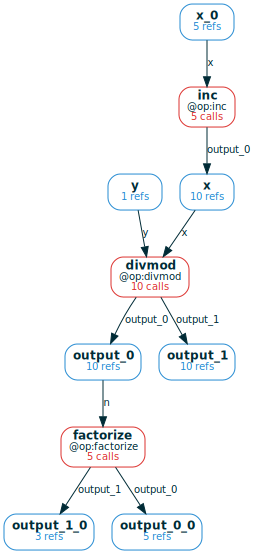

Extracting tuples from the computation graph:
    x@output_0 = inc(x=x_0)
    output_0@output_0, output_1@output_1 = divmod(x=x, y=y)
    output_0_0@output_0, output_1_0@output_1 = factorize(n=output_0)


,x_0,inc,x,y,divmod,output_0,factorize,output_0_0,output_1_0,output_1
0,NaN,None,9,1,"Call(divmod, cid='ec8...', hid='dd3...')",9.0,"Call(factorize, cid='2fa...', hid='a50...')",3.0,3.0,0.0
1,NaN,None,8,1,"Call(divmod, cid='360...', hid='60b...')",NaN,None,NaN,NaN,0.0
2,1.0,"Call(inc, cid='9ee...', hid='7b8...')",2,1,"Call(divmod, cid='ac3...', hid='261...')",NaN,None,NaN,NaN,0.0
3,NaN,None,7,1,"Call(divmod, cid='140...', hid='d89...')",NaN,None,NaN,NaN,0.0
4,3.0,"Call(inc, cid='be7...', hid='807...')",4,1,"Call(divmod, cid='185...', hid='034...')",4.0,"Call(factorize, cid='7b3...', hid='b21...')",2.0,2.0,0.0
5,4.0,"Call(inc, cid='dae...', hid='a50...')",5,1,"Call(divmod, cid='39e...', hid='00c...')",NaN,None,NaN,NaN,0.0
6,5.0,"Call(inc, cid='8d9...', hid='226...')",6,1,"Call(divmod, cid='96a...', hid='128...')",6.0,"Call(factorize, cid='4b2...', hid='109...')",2.0,3.0,0.0
7,NaN,None,6,1,"Call(divmod, cid='96a...', hid='7f4...')",NaN,None,NaN,NaN,0.0
8,2.0,"Call(inc, cid='297...', hid='f1a...')",3,1,"Call(divmod, cid='83a...', hid='9de...')",NaN,None,NaN,NaN,0.0
9,NaN,None,10,1,"Call(divmod, cid='c10...', hid='d36...')",NaN,None,NaN,NaN,0.0


In [29]:
cf = storage.cf(divmod).expand()
cf.draw(); display(cf.get_df(include_calls=True))

## Same op called in multiple places in the graph

In [7]:
storage = Storage()
with storage:
    ### we call `inc` at different stages
    inputs = [1, 2, 3, 4, 5]
    res_1 = [inc(x) for x in inputs]
    res_2 = [divmod(x, 1)[0] for x in res_1]
    res_3 = [inc(x) for x in res_2]

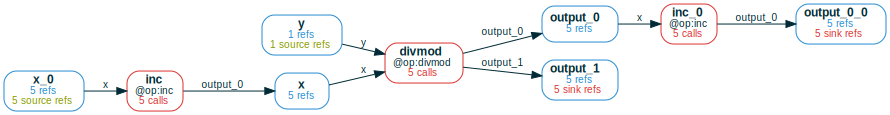

Extracting tuples from the computation graph:
    x@output_0 = inc(x=x_0)
    output_0@output_0, output_1@output_1 = divmod(x=x, y=y)
    output_0_0@output_0 = inc_0(x=output_0)


,x_0,inc,x,y,divmod,output_0,inc_0,output_0_0,output_1
0,1,"Call(inc, cid='9ee...', hid='7b8...')",2,1,"Call(divmod, cid='ac3...', hid='261...')",2,"Call(inc, cid='297...', hid='ee6...')",3,0
1,2,"Call(inc, cid='297...', hid='f1a...')",3,1,"Call(divmod, cid='83a...', hid='9de...')",3,"Call(inc, cid='be7...', hid='ed5...')",4,0
2,3,"Call(inc, cid='be7...', hid='807...')",4,1,"Call(divmod, cid='185...', hid='034...')",4,"Call(inc, cid='dae...', hid='90a...')",5,0
3,4,"Call(inc, cid='dae...', hid='a50...')",5,1,"Call(divmod, cid='39e...', hid='00c...')",5,"Call(inc, cid='8d9...', hid='a7d...')",6,0
4,5,"Call(inc, cid='8d9...', hid='226...')",6,1,"Call(divmod, cid='96a...', hid='128...')",6,"Call(inc, cid='864...', hid='c00...')",7,0


In [8]:
cf = storage.cf(divmod).expand()
cf.draw(verbose=True); display(cf.get_df(include_calls=True))

## Iterating a function on its own output

In [20]:
### iterating a function
storage = Storage()

with storage:
    start = 1
    for i in range(10):
        start = inc(start)

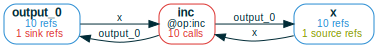

Signature: cf.merge(vars: Set[str], new_name: Optional[str] = None) -> str
Docstring: <no docstring>
Source:   
    def merge(self, vars: Set[str], new_name: Optional[str] = None) -> str:
        raise NotImplementedError()
File:      ~/workspace/current/code/projects/mandala_lite/mandala/_next/cf.py
Type:      method

In [22]:
cf = storage.cf(inc).expand()
cf.draw(verbose=True)
cf.merge??

## Another example of using a function twice in a pipeline
This time one of the uses produces elements of a list.

Currently, we can't handle this b/c of cycles.

In [14]:
storage = Storage()
with storage:
    ### create a list where elements have different computational histories
    inc_things = [inc(i) for i in range(10)]
    divmod_things = [divmod(i, 2) for i in range(10)]
    lst = inc_things + [x[0] for x in divmod_things]
    stats = get_stats(lst)
    stats_divmod = divmod(stats['avg'], stats['sum'])

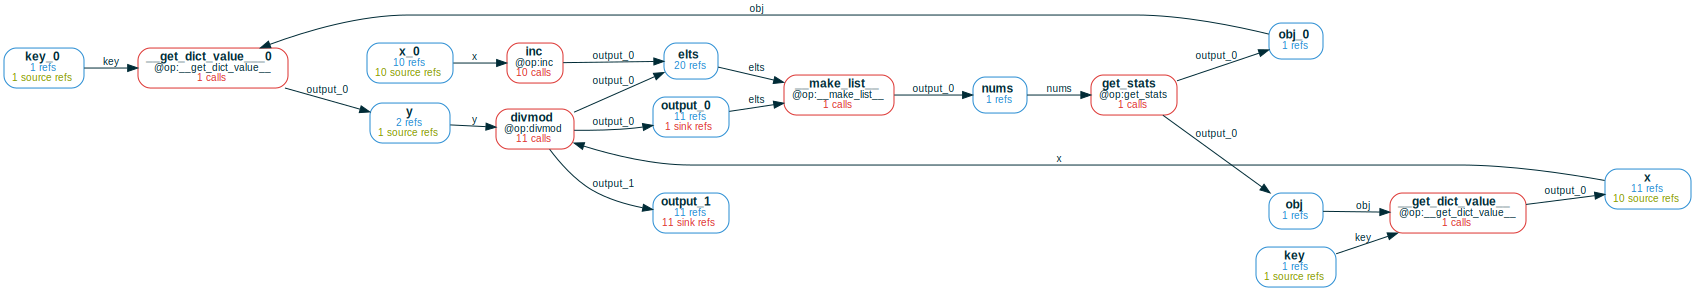

In [18]:
cf = storage.cf(divmod).expand()
cf.draw(verbose=True)
# cf.expand(reuse_existing=False).topsort()

# A "CF-complete"-ish computation
Something that will contain all the things that might happen in a computation
frame. 

In [ ]:
storage = Storage()
with storage:
    ### run the weird signature func in all the ways
    sum_1 = add(1)
    sum_2 = add(1, 2, 3, 4, )
    sum_3 = add(1, 2, 3, 4, y=5)
    sum_4 = add(1, 2, 3, 4, y=5, z=6)

    ### create a list where elements have different computational histories
    inc_things = [inc(i) for i in range(10)]
    divmod_things = [divmod(i, 2) for i in range(10)]
    lst = inc_things + [x[0] for x in divmod_things]
    stats = get_stats(lst)
    stats_divmod = divmod(stats['avg'], stats['sum'])

In [35]:

    storage = Storage()

    @op # a function with a wild input/output signature
    def add(x, *args, y: int = 1, **kwargs):
        # just sum everything
        res = x + sum(args) + y + sum(kwargs.values())
        if kwargs:
            return res, kwargs
        elif args:
            return None
        else:
            return res

    with storage:
        # call the func in all the ways
        sum_1 = add(1)
        sum_2 = add(1, 2, 3, 4, )
        sum_3 = add(1, 2, 3, 4, y=5)
        sum_4 = add(1, 2, 3, 4, y=5, z=6)
        sum_5 = add(1, 2, 3, 4, z=6, w=7)
    
    assert storage.unwrap(sum_1) == 2
    assert storage.unwrap(sum_2) == None
    assert storage.unwrap(sum_3) == None
    assert storage.unwrap(sum_4) == (15, {'z': 6})
    assert storage.unwrap(sum_5) == (16, {'z': 6, 'w': 7})


AssertionError: 

In [37]:
    storage = Storage()

    @op # a function with a wild input/output signature
    def add(x, *args, y: int = 1, **kwargs):
        # just sum everything
        res = x + sum(args) + y + sum(kwargs.values())
        if kwargs:
            return res, kwargs
        elif args:
            return None
        else:
            return res

    with storage:
        # call the func in all the ways
        sum_1 = add(1)
        sum_2 = add(1, 2, 3, 4, )
        sum_3 = add(1, 2, 3, 4, y=5)
        sum_4 = add(1, 2, 3, 4, y=5, z=6)
        sum_5 = add(1, 2, 3, 4, z=6, w=7)
    
    assert storage.unwrap(sum_1) == 2
    assert storage.unwrap(sum_2) == None
    assert storage.unwrap(sum_3) == None
    assert storage.unwrap(sum_4) == (21, {'z': 6})
    assert storage.unwrap(sum_5) == (23, {'z': 6, 'w': 7})

AssertionError: 

In [34]:
storage.unwrap(sum_3)

In [ ]:
call_hids

In [ ]:
storage.cf(divmod).get_df()

# Testing `Ignore` 

In [ ]:
storage = Storage()

@op
def inc(x: int) -> int:
    return x + 1

with storage:
    y = inc(23)
    z = inc(y)

In [ ]:
@op
def inc(x: int, y: int = NewArgDefault(1)) -> int:
    return x + y

with storage:
    y = inc(23)
    z = inc(23, 1)
    w = inc(23, y=1)
    t = inc(23, 42)

In [ ]:
storage = Storage()

@op
def do_stuff(things: list, batch_size : int = Ignore(10)) -> int:
    res = 0
    for i in range(0, len(things), batch_size):
        batch_slice = things[i:i+batch_size]
        res += sum(batch_slice)
    return res

In [ ]:
with storage:
    for i in range(1, 10):
        things = list(range(i*50))
        batch_size = random.choice([10, 20, 30])
        do_stuff(things, Ignore(batch_size))

In [ ]:
cf = storage.cf(do_stuff)

val = []
df = cf.get_df()

cf.delete_calls_from_df(df[df.things.isin([[]])])

In [ ]:
storage = Storage()

In [ ]:
with storage:
    sum_1 = add(1)
    sum_2 = add(1, 2, 3, 4, )
    sum_3 = add(1, 2, 3, 4, y=5)
    sum_4 = add(1, 2, 3, 4, y=5, z=6)

    factors = factorize(n=42)
    stats = get_stats([sum_1, sum_2, sum_3, sum_4])
    a = stats['sum']
    print(storage.attach(a))

In [ ]:
a

In [ ]:
cf = storage.cf(factorize)
cf

In [ ]:
cf_exp = cf.expand()
cf_exp.drop_func(fname='__get_list_item__')
cf_exp.drop_var(vname='output_0_0')
cf_exp

In [ ]:
cf_exp.nodes

In [ ]:
cf_exp.get_df()

In [ ]:
restricted_cf

In [ ]:
df = restricted_cf.get_joint_history_df( vnames=vnames, how="outer", include_calls=include_calls)

In [ ]:
sink_elts = restricted_cf.get_sink_elts()
restricted_cf.vnames

In [ ]:
from mandala._next.cf import ComputationFrame
restricted_cf: ComputationFrame
restricted_cf.vs['output_0']

In [ ]:
restricted_cf.consumers['0ef641fea1ee70c3c31664e9d392cbe5']

In [ ]:
self.midstream(*nodes)
vnames

In [ ]:
@op
def f(x):
    return x ** 2 + 1

@op
def g(x, y):
    return x + y

@op
def h(x):
    return x + 1


In [ ]:

storage = Storage(deps_path='__main__')

# memoizing context
with storage:
    for x in range(3):
        y = f(x)

y

In [ ]:
with storage:
    for x in range(5):
        y = f(x)
        z = g(y, h(x))
    
    for y in range(15, 20):
        z = g(y, h(x))

In [ ]:
cf = storage.cf(g); cf

In [ ]:
exp_cf = cf.expand(); exp_cf

In [ ]:
exp_cf.get_df()

In [ ]:
v = storage.get_versioner()

In [ ]:
with storage:
    for x in range(5):
        y = f(x)
        if storage.unwrap(y) > 5:
            z = g(x, y)

In [ ]:
storage.cf(f).\
  expand().\
    eval()

In [ ]:
df.rename(columns={'output_0_0': 'output_1'})

In [ ]:
cf = storage.cf(g)
cf.expand(inplace=True)
cf.eval()

In [ ]:
cf.delete_calls()

In [ ]:
@op
def avg_items(xs: MList[int]) -> float:
    return sum(xs) / len(xs)

@op
def get_xs(n: int) -> MList[int]:
    return list(range(n))

storage = Storage()

with storage:
    xs = get_xs(10)
    for i in range(2, 10, 2):
        avg = avg_items(xs[:i])

In [ ]:
cf = storage.cf(avg_items).expand()
cf.eval()

In [ ]:
storage = Storage()

@op
def inc(eggs):
    print(f'Executing inc with eggs={eggs}')
    return eggs + 1

with storage:
    spam = inc(eggs=42)

@op
def make_breakfast(spam, eggs):
    print(f'Executing make_breakfast with spam={spam} and eggs={eggs}')
    return spam + eggs

with storage:
    eggs = 42
    spam = inc(eggs=eggs)
    more_spam = inc(eggs=spam)
    breakfast = make_breakfast(spam=spam, eggs=eggs)
    breakfast_2 = make_breakfast(spam=more_spam, eggs=eggs)


cf = storage.cf(make_breakfast)
cf

cf = cf.expand()
cf.eval()

In [ ]:
storage = Storage()

### a few simple ops covering all cases we care about
@op
def f(x: int) -> int:
    return x + 1

@op
def g(x: int, y: int) -> Tuple[int, int]: # multiple inputs and outputs
    return x + 2, y ** 2

@op 
def inc_list(things: MList[int]) -> MList[int]: # lists as inputs and outputs
    return [x + 1 for x in things]

@op
def inc_dict(things: MDict[str, int]) -> MDict[str, int]: # dicts as inputs and outputs
    return {k: v + 1 for k, v in things.items()}

@op
def fancy_signature(x: int, *args, y: bool = False, **kwargs) -> Tuple[int, List[int], MList[int]]: # fancy signatures
    return x, [int(a) for a in args], [int(v) for v in kwargs.values()]

In [ ]:
### simple workflow
with storage:
    x = f(1)
    y, t = g(x, 2)
    z = inc_list([1, 2])
    z = inc_list([x, y])
    z = inc_list([1, x])
    w = inc_dict({'x': x, 'y': y})
    a = fancy_signature(1, 2, x, y=True, z=4, w=5)